In [6]:
#!pip3 install shap
#!pip install mlflow 
#!pip3 install mlflow
#!pip install pycaret  

In [1]:
import pycaret.classification as pyc
import mlflow


In [12]:
#saved_model = pyc.load_model('blended-model')
#https://towardsdatascience.com/pycaret-review-65cbe2f663bb
#https://medium.com/@data.science.enthusiast/explain-any-machine-learning-model-in-python-shap-4caf1c343f3


In [2]:
import pandas as pd
df = pd.read_csv('../diagnostico-ofertas-if/merge2018-tratado.csv')
df.head()

# Criando o novo atributo 'class'
df['class'] = df['Situação no Curso'].apply(lambda x: 1 if x == 'Evasão' else 0)

# Removendo instâncias onde o novo atributo 'class' é NaN
df = df[df['class'].notna()]

#remove sitaucao no curso
del df['Situação no Curso']
del df['Situação no Período']
del df['Ano de Conclusão']
del df['Data de Conclusão de Curso']
del df['Data do Último Procedimento']
del df['Frequência no Período']
del df['I.R.A.']
del df['Percentual de Progresso']
del df['ano_ultimo_procedimento']


# Verificando as primeiras linhas do DataFrame após as alterações
df.head()

,Unnamed: 0,Ano Letivo de Previsão de Conclusão,Ano de Ingresso,Campus,Cota MEC,Cota Sistec,Código Curso,Deficiência,Descrição do Curso,Estado Civil,...,BENEFICIARIO PROGRAMA SOCIAL,TIPO SERVICO SAUDE,FREQUENCIA ACESSO INTERNET,LOCAL ACESSO INTERNET,QUANTIDADE COMPUTADORES,QUANTIDADE NOTEBOOKS,QUANTIDADE NETBOOKS,QUANTIDADE SMARTPHONES,curso,class
0,0,2024,2023,AP,NaN,NaN,8079,NaN,"Técnico de Nivel Médio em Agropecuária, na For...",Solteiro,...,NaN,Sistema Único de Saúde - SUS,Diariamente,NaN,0.0,0.0,0.0,1.0,Técnico em Agropecuária,0
1,1,2021,2018,AP,NaN,NaN,8401,NaN,"Técnico de Nivel Médio em Informática, na Form...",Solteiro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Técnico em Informática,0
2,2,2020,2018,AP,NaN,NaN,8407,NaN,Técnico de Nível Médio em Manutenção e Suporte...,Solteiro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Técnico em Manutenção e Suporte em Informática,1
3,4,2022,2020,AP,NaN,NaN,8428,NaN,"Técnico de Nível Médio em Química, na Forma Su...",Casado,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Técnico em Química,1
4,5,2022,2019,AP,NaN,NaN,8427,NaN,"Técnico de Nível Médio em Biocombustíveis, na ...",Solteiro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Técnico em Biocombustíveis,0


In [3]:
data = df.sample(frac=0.80, random_state=42)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

print(data['class'].value_counts())
print(data_unseen['class'].value_counts())

Data for Modeling: (37357, 164)
Unseen Data For Predictions: (9339, 164)
0    28422
1     8935
Name: class, dtype: int64
0    7165
1    2174
Name: class, dtype: int64


In [4]:
# If you're using Databricks set the experiment name to the full path:
# EXPERIMENT_NAME = "/Users/username@domain/folder..."
EXPERIMENT_NAME = "exp-shap"
mlflow.set_experiment(EXPERIMENT_NAME)


# it even has a default train size of 70%
clf1 = pyc.setup(
  data,
  target="class",
  normalize=True,
  log_experiment=True,
  feature_selection_method="boruta",
  experiment_name=EXPERIMENT_NAME)

# if you're using databricks and you can't interact with the notebook
# you'll need to set silent=True and check the columns manually

,Description,Value
0,Session id,4861
1,Target,class
2,Target type,Binary
3,Original data shape,"(37357, 164)"
4,Transformed data shape,"(37357, 700)"
5,Transformed train set shape,"(26149, 700)"
6,Transformed test set shape,"(11208, 700)"
7,Ordinal features,22
8,Numeric features,26
9,Categorical features,137


In [5]:
top5_models = pyc.compare_models(
  n_select = 5,
  sort="f1")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8338,0.8781,0.8229,0.7242,0.7704,0.7261,0.7289,1.0220
xgboost,Extreme Gradient Boosting,0.8309,0.8768,0.8039,0.7260,0.7629,0.7168,0.7186,6.3950
gbc,Gradient Boosting Classifier,0.8291,0.8752,0.8133,0.7157,0.7613,0.7139,0.7167,2.2380
rf,Random Forest Classifier,0.8252,0.8746,0.7916,0.7157,0.7516,0.7018,0.7035,0.8830
lda,Linear Discriminant Analysis,0.8208,0.8683,0.8237,0.6877,0.7495,0.6964,0.7017,1.0250
lr,Logistic Regression,0.8226,0.8695,0.7990,0.7041,0.7485,0.6968,0.6994,2.6150
ridge,Ridge Classifier,0.8210,0.0000,0.8050,0.6968,0.7468,0.6940,0.6974,0.5420
ada,Ada Boost Classifier,0.8209,0.8717,0.7934,0.7019,0.7447,0.6919,0.6944,1.0270
et,Extra Trees Classifier,0.8201,0.8702,0.7703,0.7114,0.7396,0.6865,0.6875,1.0550
svm,SVM - Linear Kernel,0.8135,0.0000,0.7646,0.6957,0.7276,0.6701,0.6722,0.6520


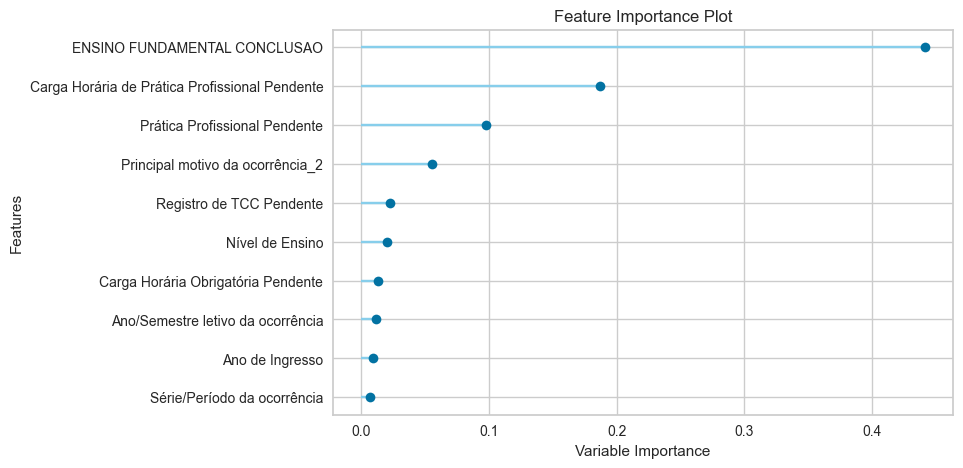

In [6]:
pyc.plot_model(top5_models[1], plot='feature')


Feature Importance do Modelo (LGBMClassifier)


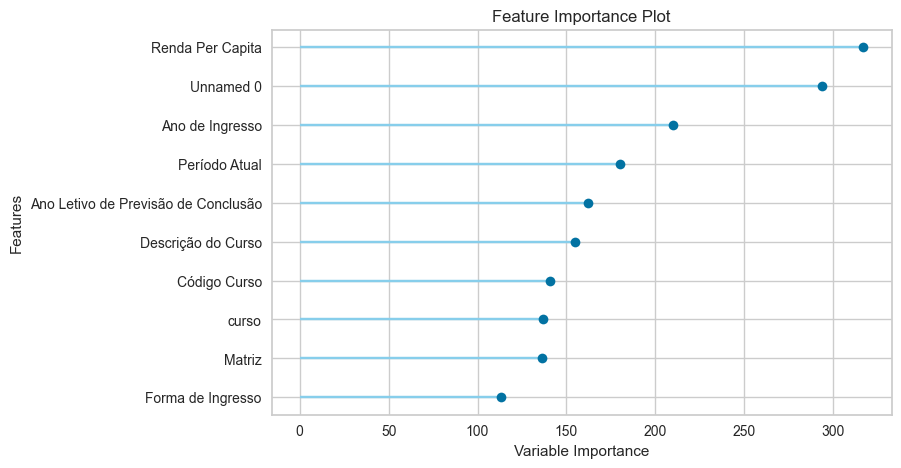

Feature Importance do Modelo (XGBClassifier)


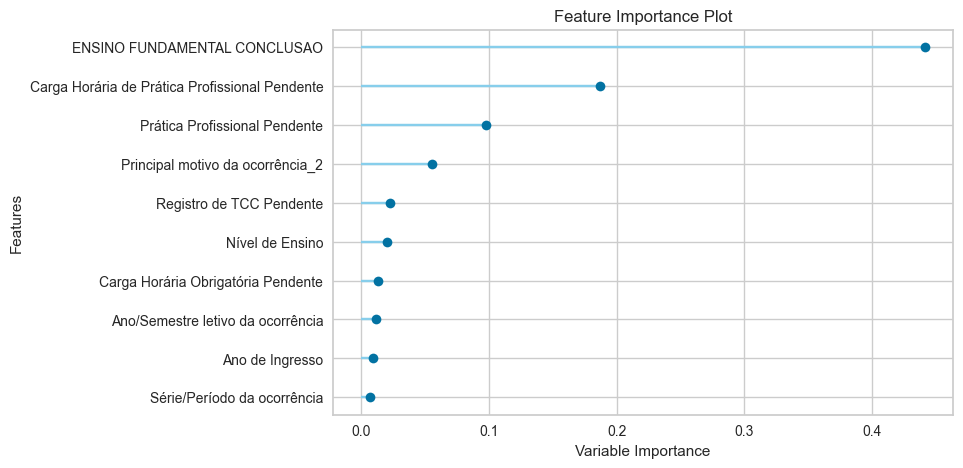

Feature Importance do Modelo (GradientBoostingClassifier)


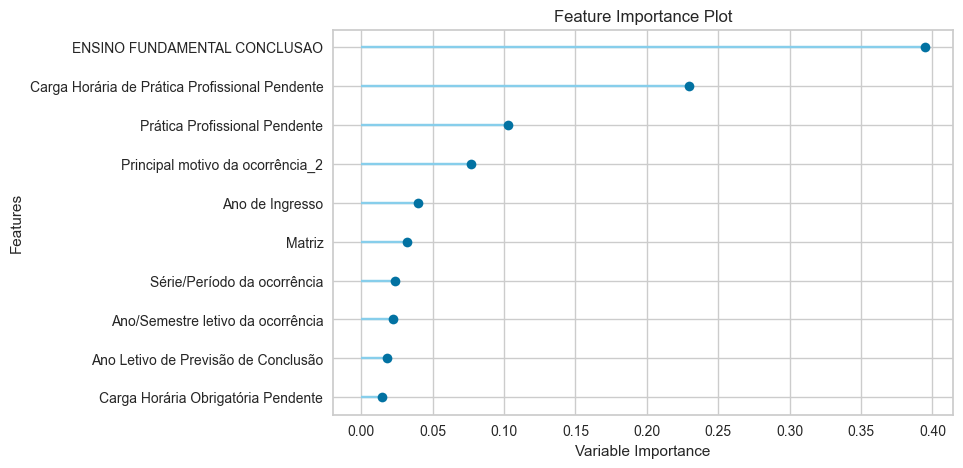

Feature Importance do Modelo (RandomForestClassifier)


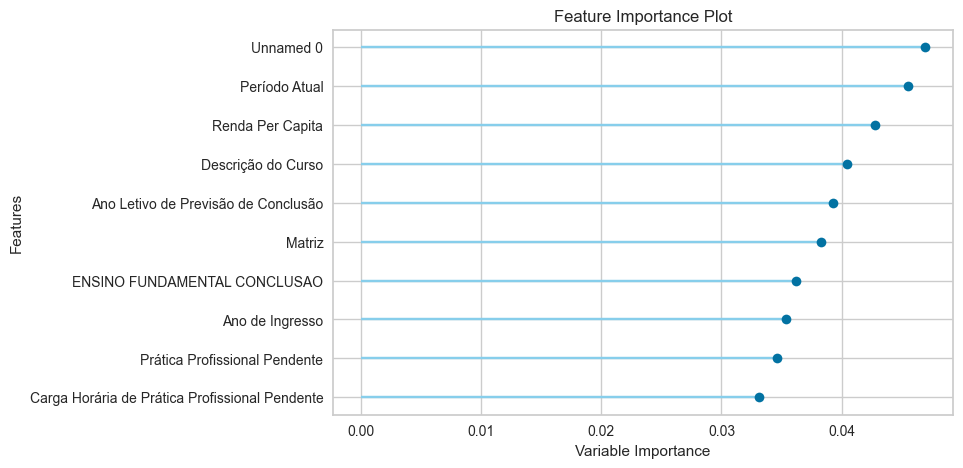

Feature Importance do Modelo (LinearDiscriminantAnalysis)


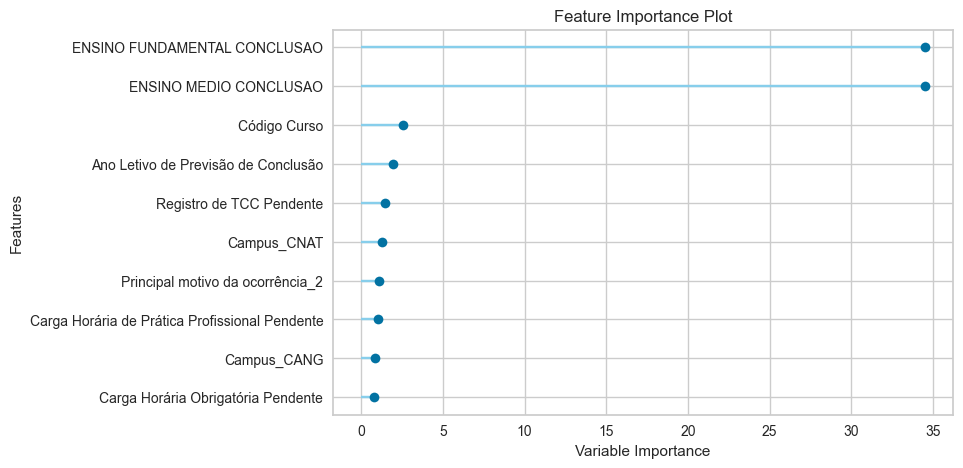

In [32]:
import matplotlib.pyplot as plt

for model in top5_models:
  #plt.figure(figsize=(12, 6))
  
  print(f"Feature Importance do Modelo ({model.__class__.__name__})")
  pyc.plot_model(model, plot='feature')#, plot_kwargs = {'title' : "teste"})

In [8]:
'''
#tunning os hiper parametros (demora bastante)
tuned_top5 = [
  pyc.tune_model(
    i,
    n_iter=100,
    optimize="f1",
    choose_better=True,
    early_stopping=True)
  for i in top5_models
  ]
  '''

'\n#tunning os hiper parametros (demora bastante)\ntuned_top5 = [\n  pyc.tune_model(\n    i,\n    n_iter=100,\n    optimize="f1",\n    choose_better=True,\n    early_stopping=True)\n  for i in top5_models\n  ]\n  '

In [9]:
blended = pyc.blend_models(
  #tuned_top5,
  top5_models,
  choose_better=True,
  optimize="f1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9335,0.9788,0.9249,0.8201,0.8694,0.8249,0.8276
1,0.9205,0.9750,0.9345,0.7779,0.8491,0.7957,0.8018
2,0.9201,0.9729,0.9201,0.7837,0.8464,0.7929,0.7976
3,0.9163,0.9717,0.9153,0.7754,0.8396,0.7834,0.7884
4,0.9205,0.9740,0.9072,0.7908,0.8450,0.7918,0.7952
5,0.9289,0.9772,0.9408,0.7978,0.8634,0.8158,0.8209
6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9247,0.9757,0.9136,0.7997,0.8529,0.8025,0.8058
8,0.9281,0.9767,0.9440,0.7941,0.8626,0.8144,0.8200


Original model was better than the blended model, hence it will be returned. NOTE: The display metrics are for the blended model (not the original one).


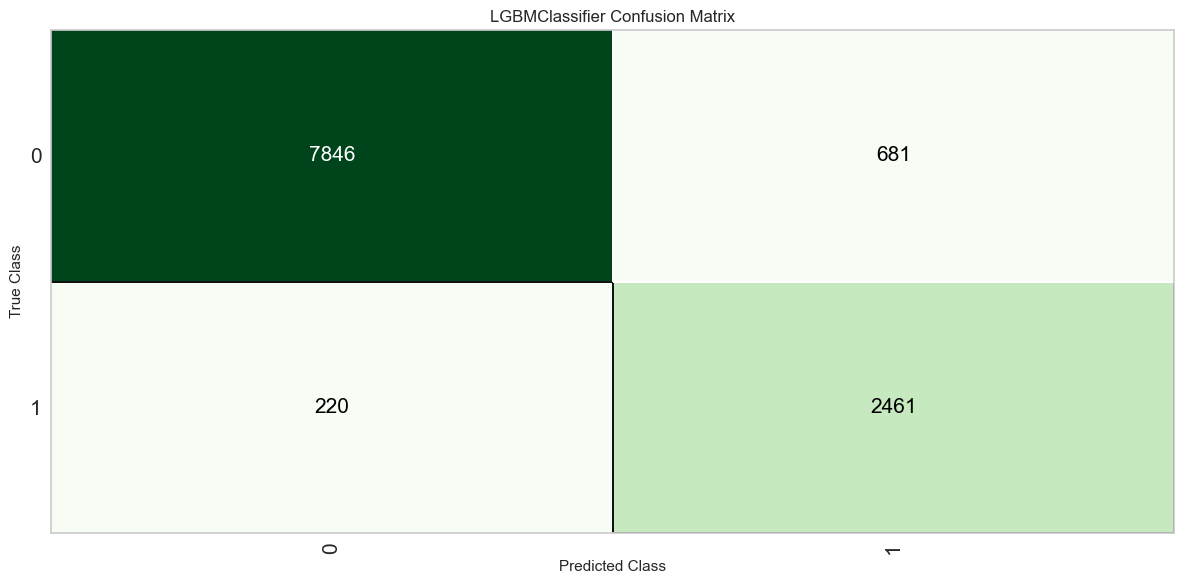

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 6))

pyc.plot_model(blended, plot='confusion_matrix')
plt.show()


In [11]:
# don't forget to run pyc.finalize_model(blended) to train on whole dataset
pred_df = pyc.predict_model(blended, data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9217,0.9746,0.9108,0.7867,0.8442,0.7923,0.7961


In [12]:
# with new Label column at the end
pred_df.head()

,Unnamed: 0,Ano Letivo de Previsão de Conclusão,Ano de Ingresso,Campus,Cota MEC,Cota Sistec,Código Curso,Deficiência,Descrição do Curso,Estado Civil,...,FREQUENCIA ACESSO INTERNET,LOCAL ACESSO INTERNET,QUANTIDADE COMPUTADORES,QUANTIDADE NOTEBOOKS,QUANTIDADE NETBOOKS,QUANTIDADE SMARTPHONES,curso,class,prediction_label,prediction_score
0,2,2020,2018,AP,NaN,NaN,8407,NaN,Técnico de Nível Médio em Manutenção e Suporte...,Solteiro,...,NaN,NaN,NaN,NaN,NaN,NaN,Técnico em Manutenção e Suporte em Informática,1,1,0.5948
1,12,2022,2018,AP,NaN,NaN,8413,NaN,Licenciatura em Química (2012) - Campus Apodi,Solteiro,...,NaN,NaN,NaN,NaN,NaN,NaN,Licenciatura em Química,0,0,0.8432
2,13,2020,2019,AP,NaN,NaN,8079,NaN,"Técnico de Nivel Médio em Agropecuária, na For...",Solteiro,...,NaN,NaN,NaN,NaN,NaN,NaN,Técnico em Agropecuária,0,0,0.9987
3,19,2025,2022,AP,NaN,NaN,8026,NaN,"Técnico de Nivel Médio em Agropecuária, na For...",Solteiro,...,Diariamente,NaN,0.0,1.0,1.0,3.0,Técnico em Agropecuária,0,0,0.9999
4,23,2024,2023,AP,NaN,NaN,8079,NaN,"Técnico de Nivel Médio em Agropecuária, na For...",Solteiro,...,Diariamente,NaN,0.0,0.0,0.0,1.0,Técnico em Agropecuária,0,0,0.9999


In [13]:
final_model = pyc.finalize_model(blended)
pyc.save_model(final_model, 'blended-model-shap')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/var/folders/fh/g5fgxqq513n014czxdxy7sfc0000gn/T/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Unnamed: 0',
                                              'Ano Letivo de Previsão de '
                                              'Conclusão',
                                              'Ano de Ingresso', 'Cota MEC',
                                              'Cota Sistec', 'Código Curso',
                                              'Período Atual',
                                              'Período Letivo de Integralização',
                                              'Período de Ingresso',
                                              'Renda Per Capita',
                                              'Ano...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, impo

In [14]:
saved_model = pyc.load_model('blended-model-shap')


Transformation Pipeline and Model Successfully Loaded


In [15]:
import shap 
shap.initjs() 

In [16]:
#dados de treino usando o pipeline salvo
train_pipe = saved_model[:-1].transform(data)

In [17]:
test_pipe = saved_model[:-1].transform(data_unseen)

In [19]:
#explainer = shap.Explainer(saved_model, train_pipe) 
#shap_values = explainer(test_pipe) 

explainer = shap.Explainer(top5_models[1], train_pipe) 
shap_values = explainer(test_pipe) 

#shap.plots.beeswarm(shap_values)

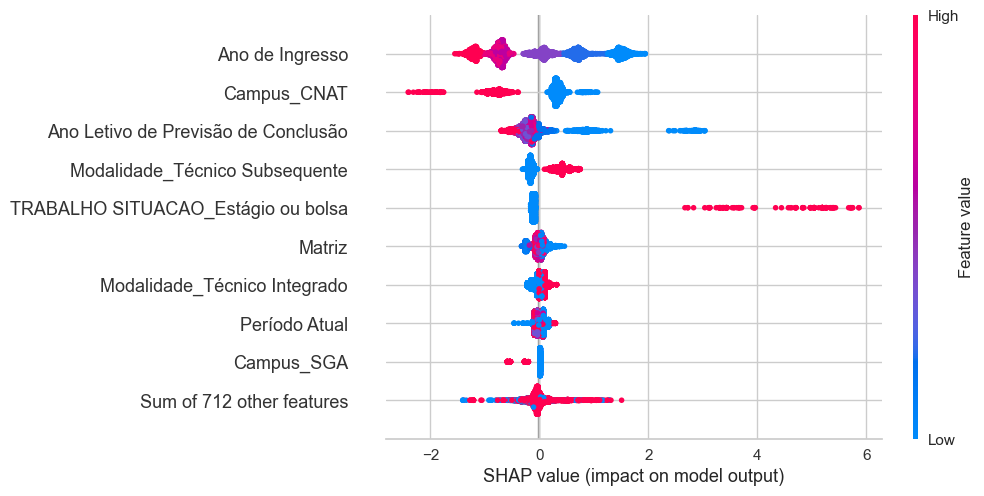

In [20]:
shap.plots.beeswarm(shap_values)

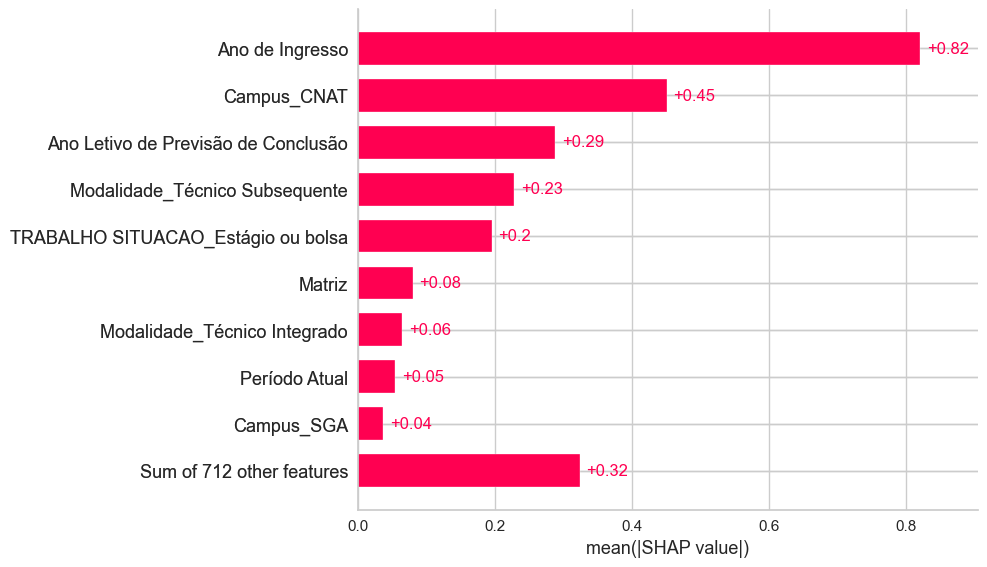

In [21]:
shap.plots.bar(shap_values)


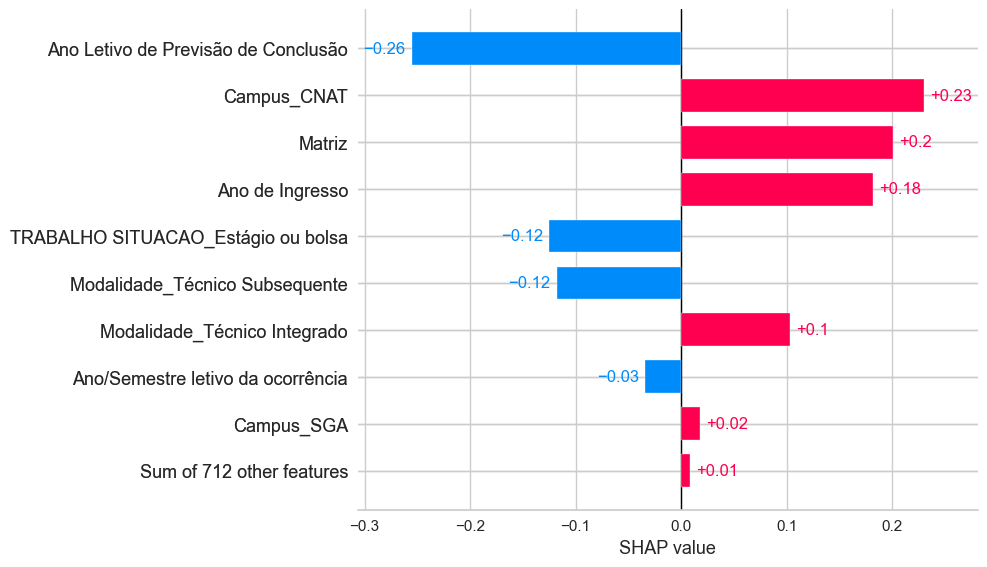

In [22]:
shap.plots.bar(shap_values[7])


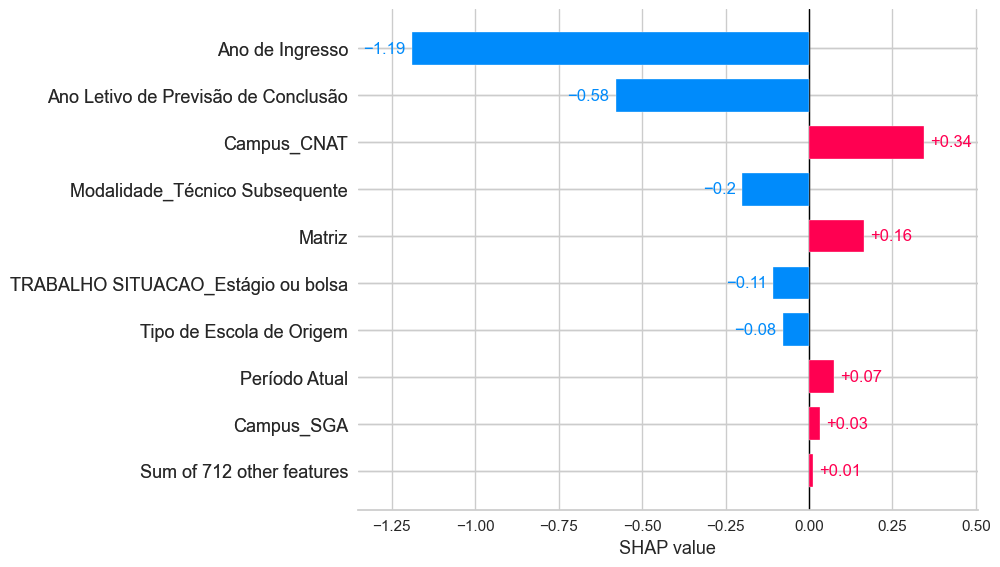

In [23]:
shap.plots.bar(shap_values[6])


Feature Importance do Modelo (LGBMClassifier)


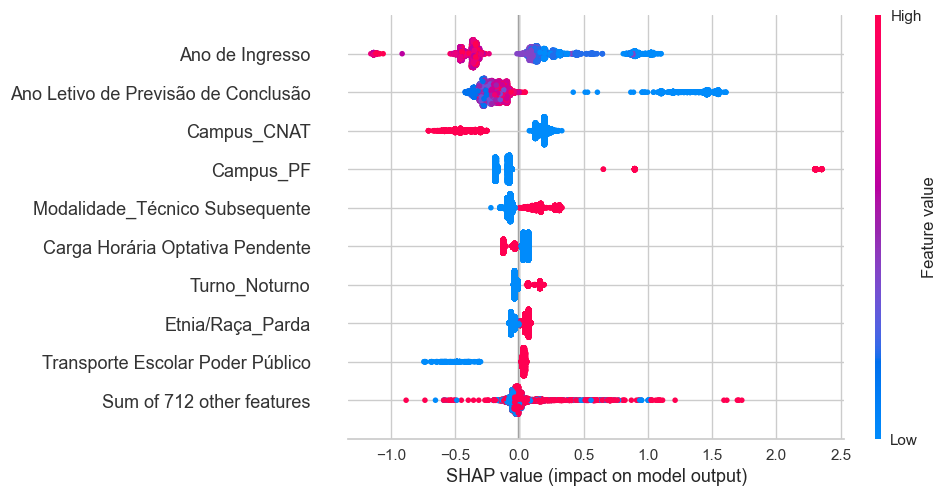

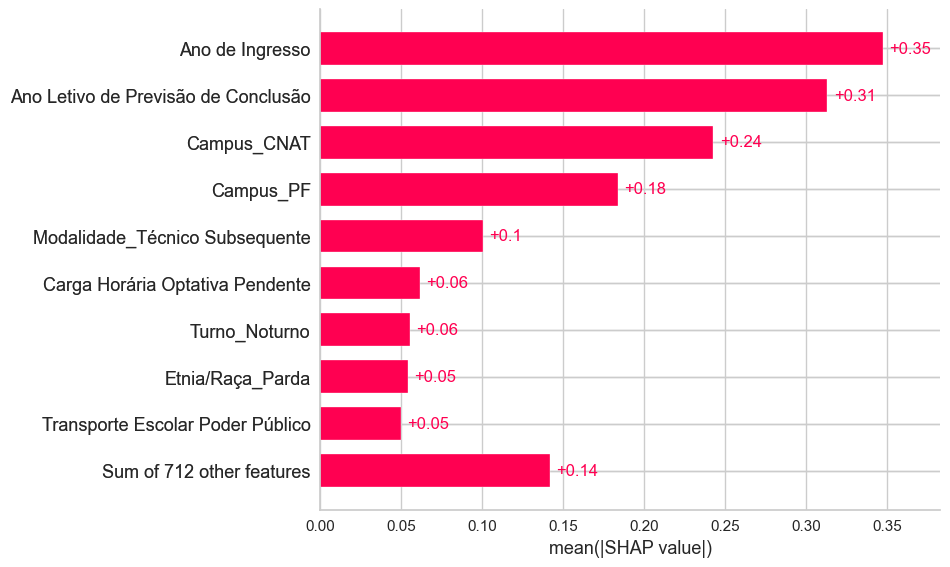

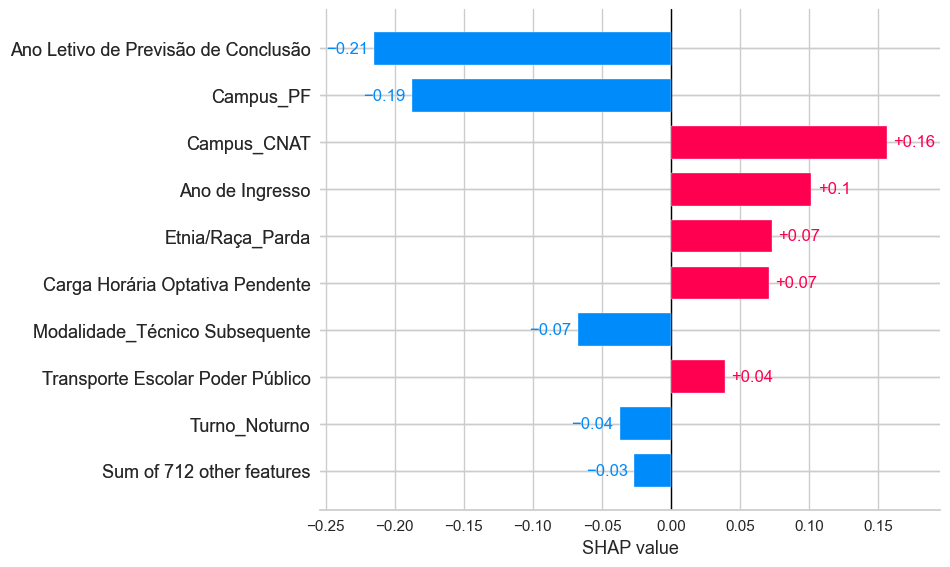

Feature Importance do Modelo (XGBClassifier)


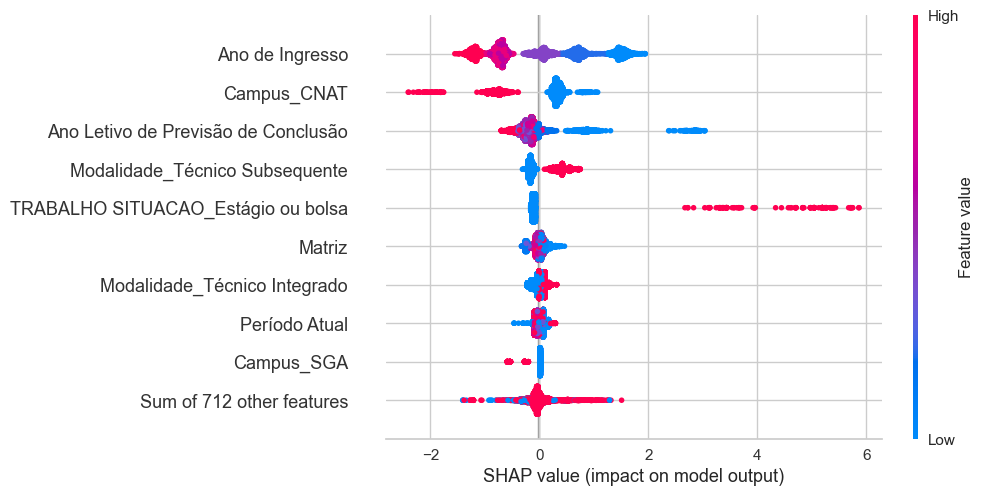

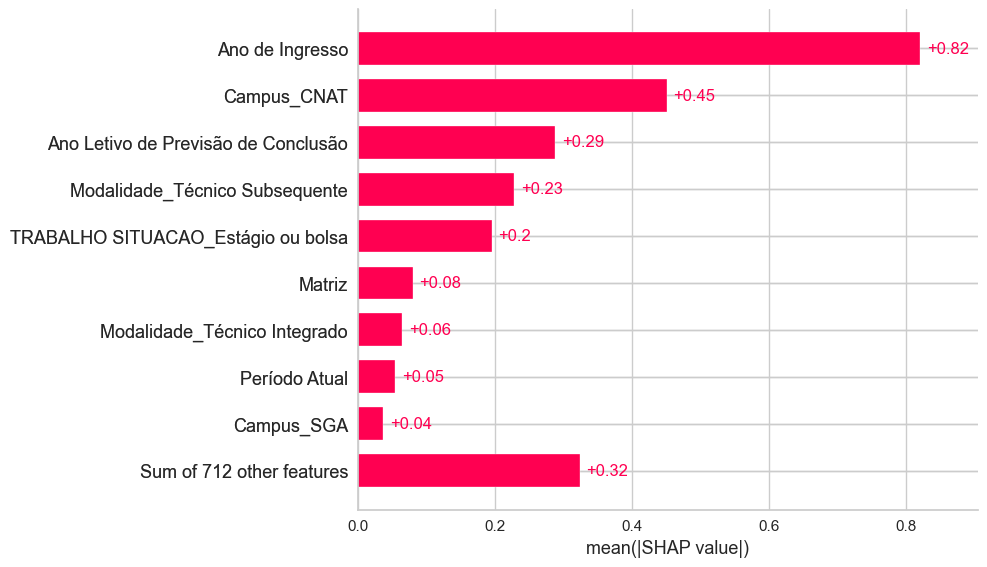

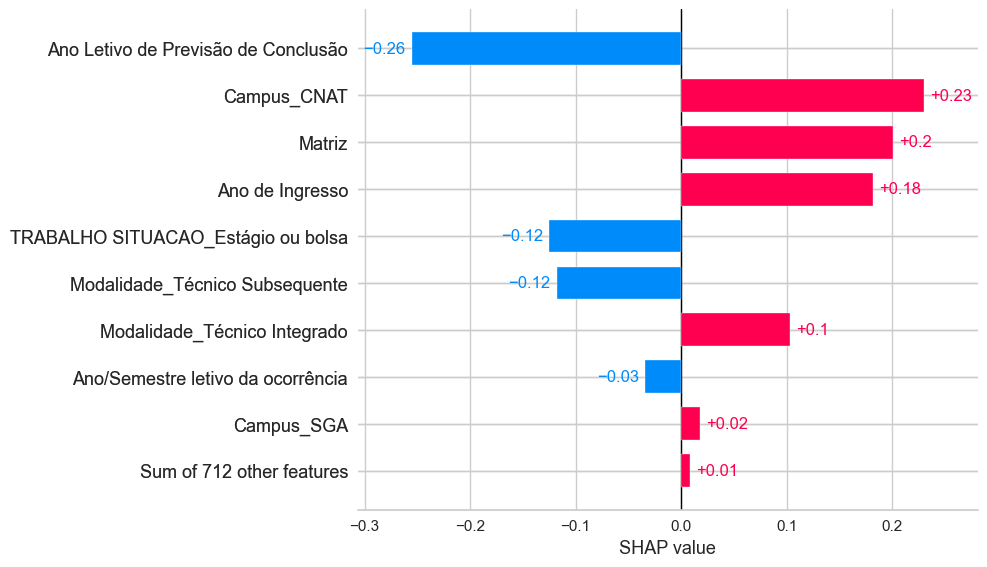

Feature Importance do Modelo (GradientBoostingClassifier)


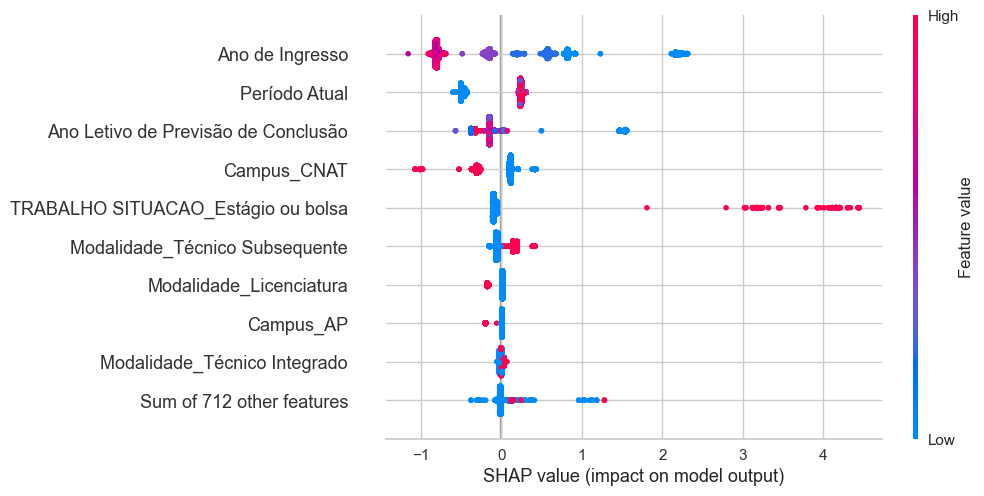

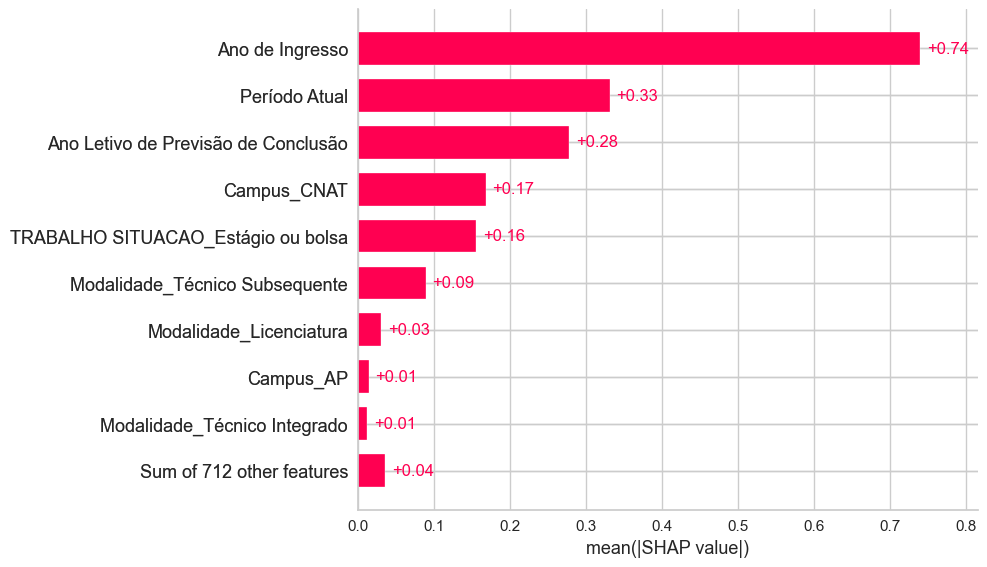

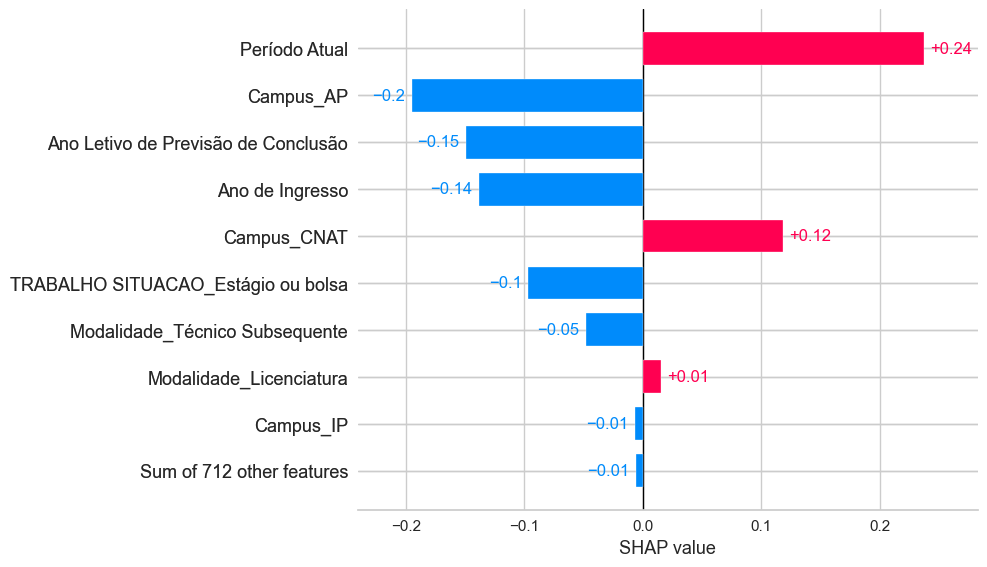

In [39]:
for model in top5_models:
    if model.__class__.__name__ in ('RandomForestClassifier', 'LinearDiscriminantAnalysis'):
        continue
    else:
        explainer = shap.Explainer(model, train_pipe) 
        shap_values = explainer(test_pipe) 

        print(f"Feature Importance do Modelo ({model.__class__.__name__})")
        shap.plots.beeswarm(shap_values)
        shap.plots.bar(shap_values)
        shap.plots.bar(shap_values[7])

